# Arsenal Data Analysis project

In this project, I'll be investigating how Arsenal perform against different playing styles.

To do this, we will need to define some metrics to describe different playing styles. Initial ideas may include:

*   Possession-based: High Possession Percentage, Short Passes, Pass Completion Rate

*   Direct/Counter-attacking: Lower Possession Percentage, higher Long Passes, Direct Pass Completion

*   High Pressing: High Pressures in the Opponent’s Half, Tackles in Final Third

*   Defensive/Compact: High Blocks, Clearances, low Expected Goals Against (xGA)

Most of the data will come from fbref.com, and we will be using data on a per-match basis.

For this project, we will only be looking at Premier league matches and will only use data from seasons in which Arteta was manager for the entire season (so from 2020/21 season).

## Section 1: Data Scraping

First, we will need to collect all relevant data.

For each Arsenal match, we will need data on:

*   Arsenal's Opponent’s Style Metrics (Possession, Pressures, Tackles, Pass Types, etc.)
*   Match Result (Win, Draw, Loss)
*   Goals Scored and Conceded

The data will be organised by season and each match will be assigned to a “style category” based on thresholds for each style metric. For instance, teams with over 60% possession could be tagged as “Possession-based.”

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

In [ ]:
def get_table(url, table_id):
  try:
    response = requests.get(url)
  except:
    print("Can't find url")
    return
  soup = BeautifulSoup(response.content, 'html.parser')

  try:
    table = soup.find('table', {'id': table_id})
  except:
    print("Can't find table")
    return
  try:
    rows = table.find_all('tr')
  except:
    print("Table is empty")
    print("url:", url)
    print("table_id:", table_id, type(table_id))
    return

  data = []

  for row in rows:
    d = {}
    row_headers = row.find_all('th')
    if row_headers:
      for header in row_headers:
        if header.get('data-stat') == 'date': # Include date column
          date = header.get_text(strip=True)
          d['date'] = date
    # Get data from each row
    cells = row.find_all('td')
    if cells:
      for cell in cells:
        d[cell.get('data-stat')] = cell.get_text(strip=True)
      data.append(d)

  df = pd.DataFrame(data)
  df = df.drop(columns=['match_report'])
  return df


In [ ]:
# Define function to get a dataframe that combines data from multiple seasons
def get_grouped_tables(url_template, season_range, matchlog, tabs, common_keys, add_season=True):
  table_id = "matchlogs_" + matchlog

  dfs = []
  for year in range(season_range[0], season_range[1]+1):
    season = str(year) + '-' + str(year+1)
    tmp_df = pd.DataFrame()
    for tab in tabs:
      url = url_template.format(season, tab)
      df = get_table(url, table_id)
      print(".", end="")
      if tmp_df.empty:
        tmp_df = df
      else:
        # existing_keys = tmp_df.keys()
        # new_keys = df.keys()
        # common_keys = [i for i in new_keys if i in existing_keys]
        # print(common_keys)
        tmp_df = pd.merge(tmp_df, df, on=common_keys, how='outer')

      time.sleep(2) # Sleep for 2 seconds before making the next request (to prevent getting blocked)

    if add_season:
      tmp_df['season'] = year # Eg. 2020/21 season would be labelled 2020

    print(season, "SEASON COMPLETE")
    dfs.append(tmp_df)
    time.sleep(5) # Sleep for 5 seconds before next loop (to prevent getting blocked)

  final_df = pd.concat(dfs, ignore_index=True)  # ignore_index re-indexes the rows
  final_df = final_df[final_df['date'] != ""] # drop rows that don't contain a date (some rows contain season totals)
  return final_df


In [ ]:
url_template = "https://fbref.com/en/squads/18bb7c10/{}/matchlogs/c9/{}/Arsenal-Match-Logs-Premier-League"
season_range = [2020, 2023]
tabs = ['passing', 'shooting', 'passing_types', 'gca', 'defense', 'possession', 'misc']
common_keys = ['date', 'start_time', 'round', 'dayofweek', 'venue', 'result', 'goals_for', 'goals_against', 'opponent']

combined_df = get_grouped_tables(url_template, season_range, 'against', tabs, common_keys)
display(combined_df)

.......2020-2021 SEASON COMPLETE
.......2021-2022 SEASON COMPLETE
.......2022-2023 SEASON COMPLETE
.......2023-2024 SEASON COMPLETE


,date,start_time,round,dayofweek,venue,result,goals_for,goals_against,opponent,passes_completed_x,...,interceptions_y,tackles_won_y,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,season
1,2020-09-12,12:30,Matchweek 1,Sat,Home,L,0,3,Fulham,485,...,10,7,0,0,0,46,8,5,61.5,2020
2,2020-09-19,20:00,Matchweek 2,Sat,Away,L,1,2,West Ham,340,...,10,5,0,0,0,34,14,16,46.7,2020
3,2020-09-28,20:00,Matchweek 3,Mon,Home,W,3,1,Liverpool,712,...,6,6,0,0,0,51,6,11,35.3,2020
4,2020-10-04,14:00,Matchweek 4,Sun,Away,L,1,2,Sheffield Utd,313,...,5,4,0,0,0,41,14,17,45.2,2020
5,2020-10-17,17:30,Matchweek 5,Sat,Home,W,1,0,Manchester City,604,...,8,5,0,0,0,47,15,12,55.6,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,2024-04-23,20:00,Matchweek 29,Tue,Away,L,0,5,Chelsea,567,...,7,5,0,0,0,53,11,12,47.8,2023
152,2024-04-28,14:00,Matchweek 35,Sun,Home,L,2,3,Tottenham,525,...,8,12,1,0,1,45,9,13,40.9,2023
153,2024-05-04,12:30,Matchweek 36,Sat,Away,L,0,3,Bournemouth,314,...,10,9,0,1,0,40,19,15,55.9,2023
154,2024-05-12,16:30,Matchweek 37,Sun,Home,L,0,1,Manchester Utd,458,...,5,12,0,0,0,45,13,10,56.5,2023


In [ ]:
total_df = combined_df.copy()

total_df['flag_win'] = np.where(total_df['result'] == 'L', 1, 0) # Opposite way round as W/L refers to opponent
total_df['flag_lose'] = np.where(total_df['result'] == 'W', 1, 0) # Opposite way round as W/L refers to opponent
total_df['flag_draw'] = np.where(total_df['result'] == 'D', 1, 0)

def safe_to_numeric(x):
    # Try to convert to numeric if x is a string
    if isinstance(x, str):
        try:
            return pd.to_numeric(x, errors='raise')
        except ValueError:
            return x
    return x

total_df = total_df.applymap(safe_to_numeric)
total_df['goal_dif'] = total_df['goals_against'] - total_df['goals_for'] # (Data is for the opponent so goal dif is backwards)

<ipython-input-68-cf174f4c513d>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  total_df = total_df.applymap(safe_to_numeric)


In [ ]:
print(list(total_df.keys()))
if len(total_df.keys()) != len(set(total_df.keys())):
  print("THERE ARE REPEATED KEYS")

['date', 'start_time', 'round', 'dayofweek', 'venue', 'result', 'goals_for', 'goals_against', 'opponent', 'passes_completed_x', 'passes_x', 'passes_pct', 'passes_total_distance', 'passes_progressive_distance', 'passes_completed_short', 'passes_short', 'passes_pct_short', 'passes_completed_medium', 'passes_medium', 'passes_pct_medium', 'passes_completed_long', 'passes_long', 'passes_pct_long', 'assists', 'xg_assist', 'pass_xa', 'assisted_shots', 'passes_into_final_third', 'passes_into_penalty_area', 'crosses_into_penalty_area', 'progressive_passes', 'goals', 'shots', 'shots_on_target', 'shots_on_target_pct', 'goals_per_shot', 'goals_per_shot_on_target', 'average_shot_distance', 'shots_free_kicks', 'pens_made', 'pens_att', 'xg', 'npxg', 'npxg_per_shot', 'xg_net', 'npxg_net', 'passes_y', 'passes_live', 'passes_dead', 'passes_free_kicks', 'through_balls', 'passes_switches', 'crosses_x', 'throw_ins', 'corner_kicks', 'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight', 'passes_com

# Possession-style index (PSI)

Here is the proposed metric that we will use to characterise how 'possession based' a teams style is in a given match.

$PSI = Possession \times PassingAccuracy \times \frac{ShortPasses}{Passes} \times \frac{TouchesDef3rd + TouchesMid3rd}{Touches}$



Text(0, 0.5, 'PSI')

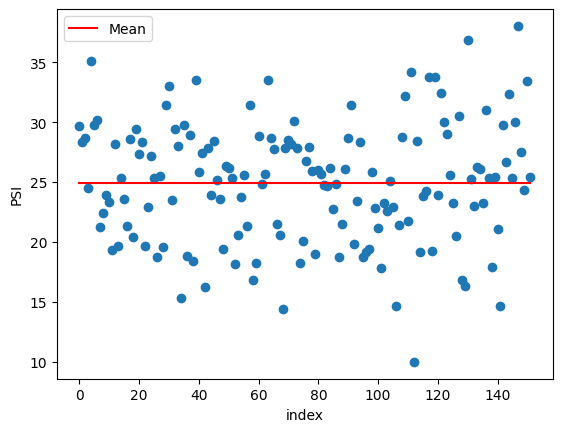

In [ ]:
# total_df['PSI'] = (total_df['possession'] * total_df['passes_pct'] *
#                    total_df['passes_short']/total_df['passes_x'] *
#                    (total_df['touches_def_3rd'] + total_df['touches_mid_3rd'])/total_df['touches'])

total_df['PSI'] = (total_df['passes_pct'] *
                   total_df['passes_short']/total_df['passes_x'] *
                   (total_df['touches_def_3rd'] + total_df['touches_mid_3rd'])/total_df['touches'])

n = len(total_df['PSI'])
av = sum(total_df['PSI'])/n

plt.scatter(range(n), total_df['PSI'])
av_line = [av for i in range(n)]
plt.plot(range(n), av_line, color='r', label='Mean')
plt.legend()
plt.xlabel('index')
plt.ylabel('PSI')

## Classify teams (binary)

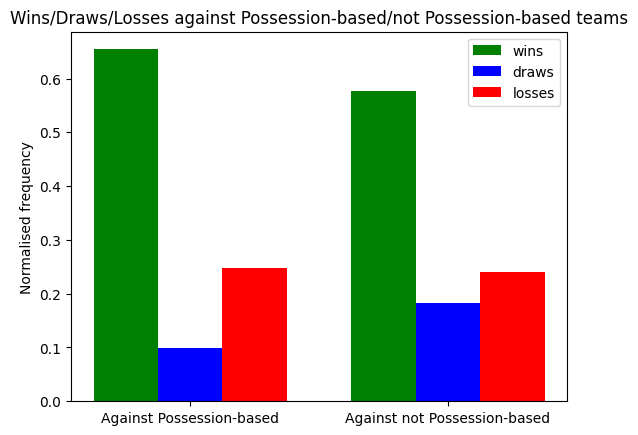

In [ ]:
p_data = [] # opposition are possession based
np_data = [] # opposition are not possession based
for i in range(n):
  w, d, l = total_df[['flag_win', 'flag_draw', 'flag_lose']].iloc[i]
  if total_df['PSI'].iloc[i] > av:
    p_data.append([w, d, l])
  else:
    np_data.append([w, d, l])


# Calculate sums for each sub-bar (column-wise sum)
p_sums = np.sum(p_data, axis=0)
p_sums = p_sums/sum(p_sums)
np_sums = np.sum(np_data, axis=0)
np_sums = np_sums/sum(np_sums)

bar_width = 0.25  # width of the bars
index = np.arange(2)  # Two main bars

# Plot the bar chart
fig, ax = plt.subplots()

# Plot each sub-bar for the first main bar
ax.bar(index[0] - bar_width, p_sums[0], bar_width, label='wins', color='g')
ax.bar(index[0], p_sums[1], bar_width, label='draws', color='b')
ax.bar(index[0] + bar_width, p_sums[2], bar_width, label='losses', color='r')

# Plot each sub-bar for the second main bar
ax.bar(index[1] - bar_width, np_sums[0], bar_width, color='g')
ax.bar(index[1], np_sums[1], bar_width, color='b')
ax.bar(index[1] + bar_width, np_sums[2], bar_width, color='r')

# Add labels and title
# ax.set_xlabel('Main Bars')
ax.set_ylabel('Normalised frequency')
ax.set_title('Wins/Draws/Losses against Possession-based/not Possession-based teams')

# Customize the x-ticks to show the two main bars
ax.set_xticks(index)
ax.set_xticklabels(['Against Possession-based', 'Against not Possession-based'])

# Add a legend
ax.legend()

# Show the plot
plt.show()

No. Matches: 152
No. Wins: 94


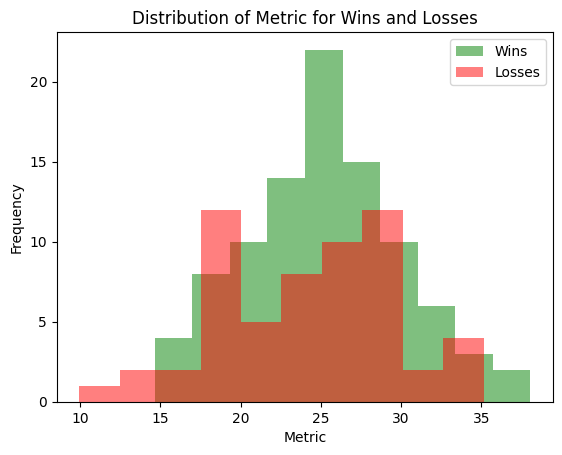

In [ ]:
metric = list(total_df['PSI'])
results = list(total_df['flag_win'])
print("No. Matches:", len(results))
print("No. Wins:", sum(results))
# Separate the metrics based on win (1) and loss (0)
wins_metric = []
losses_metric = []
for i in range(len(metric)):
  if results[i] == 0:
    losses_metric.append(metric[i])
  else:
    wins_metric.append(metric[i])

# Plot histograms for wins and losses
plt.hist(wins_metric, bins=10, alpha=0.5, label='Wins', color='g')
plt.hist(losses_metric, bins=10, alpha=0.5, label='Losses', color='r')

# Add labels and title
plt.xlabel('Metric')
plt.ylabel('Frequency')
plt.title('Distribution of Metric for Wins and Losses')
plt.legend()

# Show the plot
plt.show()

## Attacking play index (API)

$API = \frac{LongPasses}{TotalPasses} \times \frac{TotalShots}{NumberOfProgressivePasses}
\times \frac{NumberOfProgressivePasses}{TotalPasses}$

